In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [2]:
# -- import --
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW, ElectraTokenizer
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report

# GPU 사용
device = torch.device("cuda")

In [3]:
# -- newly_reduced_bungae_df --
df = pd.read_csv('/content/drive/MyDrive/newly_reduced_bungae_df.csv', lineterminator='\n') # 이걸로 오류 해결
df['id'] = df['id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df['maincat_id'] = df['maincat_id'].astype(str)
df['midcat_id'] = df['midcat_id'].astype(str)
df.head()

,id,name,info,cat_id,tag,maincat_id,midcat_id
0,202546050,알토라쿤잠바,알토 라쿤잠바입니다 55사이즈네요 모자털 탈부착가능합니다,310300200,"알토,라쿤,잠바",310,310300
1,175146200,코스 오라리맛 푸퍼 다크브라운 40 판매합니다 (코스 다운 패디드 푸퍼),새상품 판매해요 택포,310300200,"코스푸퍼,코스,푸퍼",310,310300
2,213905890,[S] 커버낫 숏패딩,세탁완료! 깨끗하게 입었습니다 지퍼가 잘 됐다 안됐다 그럽니다;; 저는 똑딱이로 ...,310300200,"커버낫,숏,다운,오리털,패딩",310,310300
3,216998343,더 틸버리 구스패딩,55/한겨울 코트속에 이른봄은 외투로 활용도 높은 구스패딩입니다 컨디션최상~,310300200,더틸버리,310,310300
4,225515936,Sinoon 시눈 패딩 ELIN PATCHED PADDING,택 달려있어요 잠깐 외출할 때 몇번 입었구 하자 없습니다~!,310300200,"시눈,sinoon,패딩,프레클,스푸닝",310,310300


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          109248 non-null  object
 1   name        109248 non-null  object
 2   info        108882 non-null  object
 3   cat_id      109248 non-null  object
 4   tag         99639 non-null   object
 5   maincat_id  109248 non-null  object
 6   midcat_id   109248 non-null  object
dtypes: object(7)
memory usage: 5.8+ MB


In [5]:
# -- preprocessing --

def split_data(df):
    # format changes
    df['name'] = "[CLS] " + df['name'] + " [SEP]"

    # encoding
    encoder = LabelEncoder()
    # df['label'] = encoder.fit_transform(df['maincat_id']) # 대분류
    df['label'] = encoder.fit_transform(df['midcat_id']) # 중분류
    # df['label'] = encoder.fit_transform(df['cat_id']) # 소분류

    # train, test dataset split
    train_x, test_x, train_y, test_y = train_test_split(df['name'], df['label'].values, random_state=42, test_size=0.2)
    train_df, test_df = df.loc[train_x.index], df.loc[test_x.index]
    return train_df, test_df

train_df, test_df = split_data(df)

In [6]:
# -- converting inputs --
def convert_input(sentences):
    tokenizer = DistilBertTokenizer.from_pretrained("monologg/distilkobert")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

input_ids, attention_masks = convert_input(train_df['name'])

In [7]:
# -- train and validation set --
def split_train_and_validation(input_ids, attention_masks):
    train_x, val_x, train_y, val_y = train_test_split(input_ids, train_df['label'].values, random_state=5, test_size=.2)
    train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=5, test_size=.2)

    # tensor로 만들기
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    train_mask = torch.tensor(train_mask)

    val_x = torch.tensor(val_x)
    val_y = torch.tensor(val_y)
    val_mask = torch.tensor(val_mask)

    # dataloader
    batch_size = 32
    train_data = TensorDataset(train_x, train_mask, train_y)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    val_data = TensorDataset(val_x, val_mask, val_y)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = split_train_and_validation(input_ids, attention_masks)

In [8]:
# -- setting device --
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [9]:
# DistilKoBert
class DistilBertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("monologg/distilkobert")
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Take the first token's representation
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits


# model = DistilBertClassifier(num_labels=train_df['maincat_id'].nunique()) # 대분류
model = DistilBertClassifier(num_labels=train_df['midcat_id'].nunique()) # 중분류
# model = DistilBertClassifier(num_labels=train_df['cat_id'].nunique()) # 소분류

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
total_steps = len(train_dataloader) * epochs
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at monologg/distilkobert were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

model.zero_grad()
loss_list, acc_list = [], []
for epoch in tqdm(range(0, epochs)):
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(logits, b_labels)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions = np.argmax(logits, axis=1)
        accuracy = accuracy_score(label_ids, predictions)
        eval_accuracy += accuracy
        nb_eval_steps += 1

    acc_list.append(round(eval_accuracy / nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy : 0.15


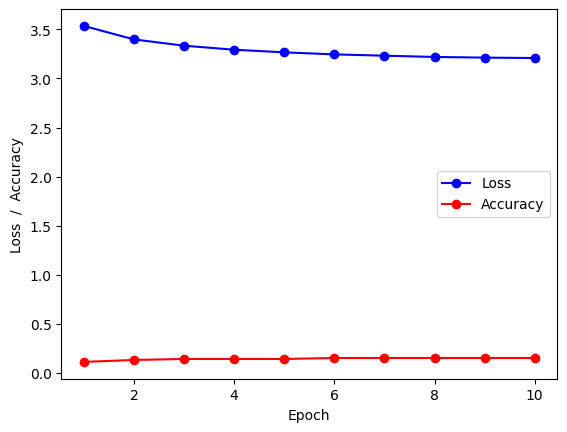

In [11]:
# -- mid category loss and accuracy --
epoch = range(1, epochs+1)
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 2)}')

In [ ]:
# -- main category loss and accuracy --
epoch = range(1, epochs+1)
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 2)}')